# Wave equation to frequency domain

This notebook is based on the Devito tutorial:

[17 - On-the-fly discrete Fourier transform | Devito](https://www.devitoproject.org/examples/seismic/tutorials/17_fourier_mode.html)

### On-the-fly Fourier Transform

The discrete Fourier transform (DFT) is defined as:

$$ X_k = \sum_{n=0}^{N-1} x_n e^{-i 2 \pi k n / N} $$

where: - $X_k$ is the DFT of the sequence $x_n$ - $N$ is the number of samples - $k$ is the frequency index - $n$ is the time index

the DFT can be used to compute the frequency components of the wavefield as it propagates through the subsurface.

The key idea is to update the Fourier modes at each time step using the current wavefield values:

$$ F_k(t+\Delta t) = F_k(t) + u(t) e^{-i \omega_k t \Delta t} $$

where: - $F_k(t)$ is the Fourier mode at frequency $\omega_k$ and time $t$ - $u(t)$ is the wavefield at time $t$ - $\Delta t$ is the time step

In [1]:
from devito import *
from examples.seismic import demo_model, AcquisitionGeometry, plot_velocity
import matplotlib.pyplot as plt

Operator `initdamp` ran in 0.01 s


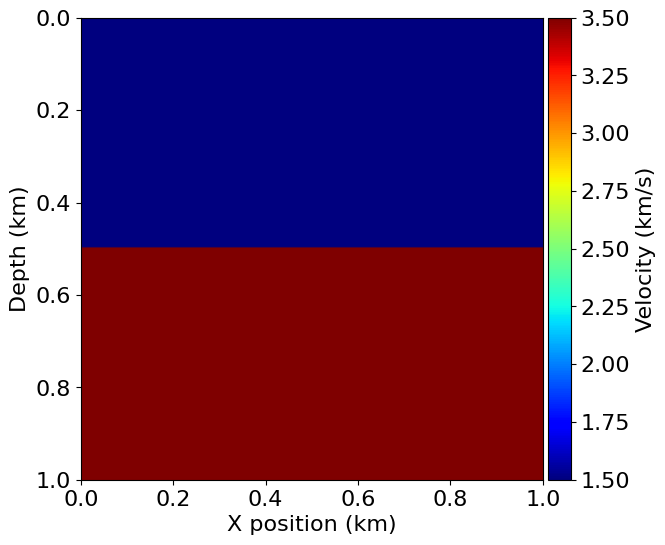

In [2]:
model = demo_model('layers-isotropic', vp=3.0, origin=(0., 0.), shape=(201, 201), spacing=(5., 5.), nbl=150, nlayers=2)
plot_velocity(model)

In [3]:
# Define acquisition geometry: source

# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, -1] = 20.  # Depth is 20m

# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
nreceivers = 201
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 30.

# Geometry
t0 = 0.
tn = 1000.  # Simulation last 1 second (1000 ms)
dt = model.critical_dt
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=.010, src_type='Ricker')

In [4]:
# Define the wavefield with the size of the model and the time dimension
u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)

# We can now write the PDE
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt

# Stencil update
stencil = Eq(u.forward, solve(pde, u.forward))
stencil

Eq(u(t + dt, x, y), (-(-2.0*u(t, x, y)/dt**2 + u(t - dt, x, y)/dt**2)/vp(x, y)**2 + Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + damp(x, y)*u(t, x, y)/dt)/(damp(x, y)/dt + 1/(dt**2*vp(x, y)**2)))

In [5]:
nfreq = 5
f = Dimension(name='f')

frequencies = Function(name='frequencies', dimensions=(f,), shape=(nfreq,), dtype=np.float32)
frequencies.data[:] = np.linspace(0.005, 0.01, num=nfreq)

freq_modes = Function(name='freq_modes', grid=model.grid, space_order=0, dtype=np.complex64,
                      dimensions=(f, *model.grid.dimensions), shape=(nfreq, *model.grid.shape))

omega = 2 * np.pi * frequencies
basis = exp(-1j * omega * model.grid.time_dim * model.grid.time_dim.spacing)
dfts = [Inc(freq_modes, basis * u)]

In [6]:
# Define the source injection and receiver read function to generate the corresponding code
src = geometry.src
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec = geometry.rec
rec_term = rec.interpolate(expr=u.forward)

In [7]:
op = Operator([stencil] + src_term + rec_term + dfts, subs=model.spacing_map)

In [8]:
u.data.fill(0)
op(dt=model.critical_dt)

Operator `Kernel` ran in 0.64 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.13998599999999986, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0003660000000000024, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0018030000000000008, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.0007470000000000107, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section4', rank=None),
                     PerfEntry(time=0.4884380000000004, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

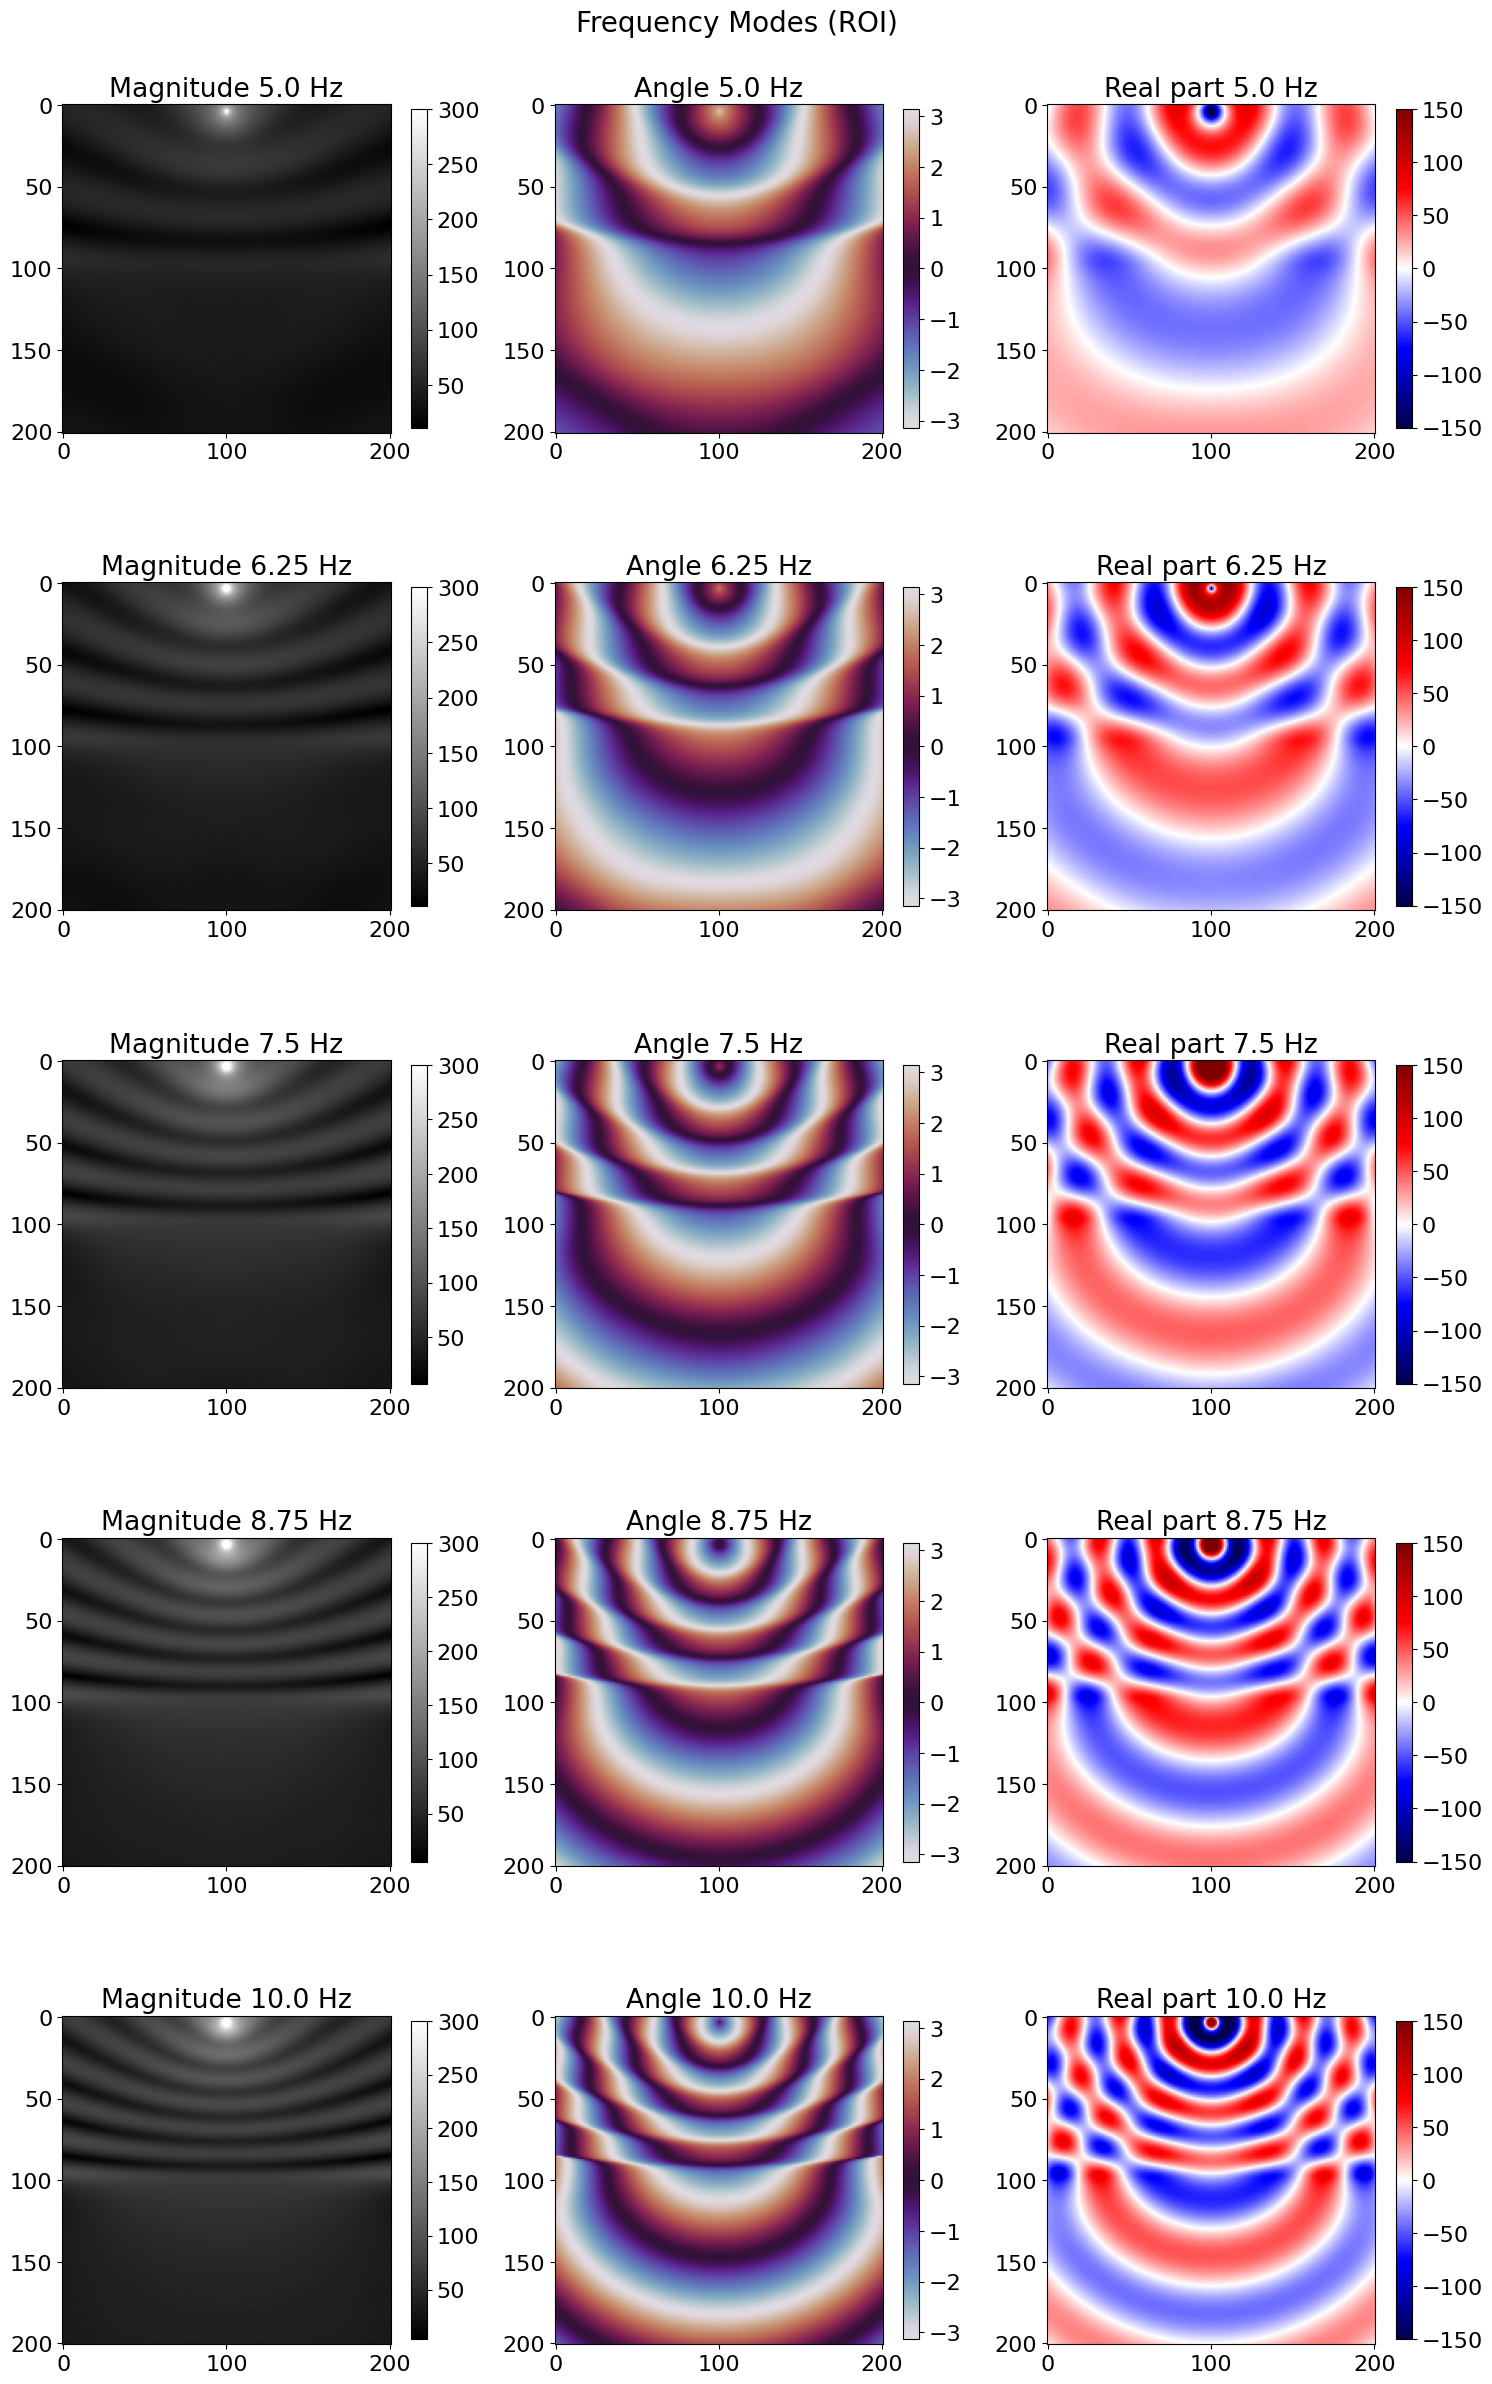

In [9]:
plt.figure(figsize=(18, 30))
plt.suptitle('Frequency Modes (ROI)', fontsize=20, y=0.9)

for i in range(nfreq):
    plt.subplot(5, 3, 3*i+1)
    im1 = plt.imshow(np.abs(freq_modes.data[i].T[model.nbl:-model.nbl, model.nbl:-model.nbl]), cmap='gray', vmax=3e2)
    plt.title(f'Magnitude {1e3*frequencies.data[i]} Hz')
    plt.colorbar(im1, shrink=0.8)

    plt.subplot(5, 3, 3*i+2)
    im2 = plt.imshow(np.angle(freq_modes.data[i].T[model.nbl:-model.nbl, model.nbl:-model.nbl]), cmap='twilight', vmin=-np.pi, vmax=np.pi)
    plt.title(f'Angle {1e3*frequencies.data[i]} Hz')
    plt.colorbar(im2, shrink=0.8)

    plt.subplot(5, 3, 3*i+3)
    im3 = plt.imshow(np.real(freq_modes.data[i].T[model.nbl:-model.nbl, model.nbl:-model.nbl]), cmap='seismic', vmin=-1.5e2, vmax=1.5e2)
    plt.title(f'Real part {1e3*frequencies.data[i]} Hz')
    plt.colorbar(im3, shrink=0.8)

plt.show()